In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from konlpy.tag import Okt
from wordcloud import WordCloud
import re
import json
from nltk import ngrams
from itertools import chain

## 데이터 로드

In [2]:
# 파일 경로
# 원하는 파일 경로 지정
path = 'C:/D/공부/대학원/연구실/프로젝트/LG/데이터/'

styler_ai = pd.read_csv(path + '의류관리기_AI모델.csv')
styler_gen = pd.read_csv(path + '의류관리기_일반모델.csv')
styler_vs = pd.read_csv(path + '의류관리기_비교글.csv')

In [3]:
styler_ai.head()

,title,content,date,link,platform
0,LG 화면 구부러지는 TV로 게임한다 LG전자 강남에 금성오락실 열어 외 34건 O...,LG 디스클로저 K뉴스헤드라인 K헤드라인 knews 한국외신뉴스 한국상장회사 화면 ...,2022-10-13,https://blog.naver.com/disclosurekorea/2228989...,blog
1,대용량 건조기의 리더 삼성 디지털프라자 BESPOKE 그랑데 건조기 AI 20kg ...,BESPOKE 그랑데 건조기 AI 20kg20kg 대용량 건조기의 리더 안녕하세요 ...,2022-01-14,https://blog.naver.com/crystaltour/222621692431,blog
2,HAPPY 나답게 YEAR 공유이벤트 나의옷장으로,2022년은 나답게 보내볼까요 할머니의옷장에서 나의옷장으로 요즘은 빈티지가 유행이지...,2022-01-14,https://blog.naver.com/meeya00/222621676988,blog
3,삼성 그랑데AI 드럼 건조기세탁기 추천 삼성 디지털프라자 방문기,드럼 세탁기 건조기 제품을 찾을 때 과거에는 용량이 크지 않는 제품을 선호하기도 했...,2022-12-30,https://blog.naver.com/gyoil/222970521388,blog
4,평촌골프 최고의 시설에서 골프 레슨 받고 싱글 플레이어 도전,안녕하세요 4계절 중 골프치기 가장 좋은 계절이 왔습니다 8월 말부터 필드에는 시원...,2022-09-02,https://blog.naver.com/fitin_golf/222865120695,blog


## 추가 전처리

In [4]:
# 불용어 목록
irrelevant_title = [
    '분양','오피스텔','분양안내','분양정보','부동산','분양소식','모델하우스','아파트','힐스테이트',
    '평촌골프', '골프연습장', '레슨', '골프', '안양골프장', '피트인골프존'
]

irrelevant_content = [
    '테크컨퍼런스', '분양','오피스텔','분양안내','분양정보','부동산','분양소식','모델하우스','중고차','힐스테이트',
    '평촌골프', '골프연습장', '레슨', '골프', '안양골프장', '피트인골프존'
]

def remove_irrelevant(data, title_keywords, content_keywords):
    # 제목의 불용어 패턴 생성
    title_pattern = '|'.join(title_keywords)
    # 내용의 불용어 패턴 생성
    content_pattern = '|'.join(content_keywords)

    # 제목 또는 내용에서 불용어가 포함된 행 제거
    filtered_data = data[
        ~data['title'].str.contains(title_pattern, case=False, na=False) &
        ~data['content'].str.contains(content_pattern, case=False, na=False)
    ]

    return filtered_data

In [5]:
# 파일 경로
path = '/content/'

styler_ai = remove_irrelevant(styler_ai, irrelevant_title, irrelevant_content)
styler_gen = remove_irrelevant(styler_gen, irrelevant_title, irrelevant_content)
styler_vs = remove_irrelevant(styler_vs, irrelevant_title, irrelevant_content)

## 불용어, n-gram 등 전처리

### 특정 단어 병합 후 n-gram 확인

* 노이즈 제거 (특정 단어 병합) 후 trigram, bigram에서 나온거를 붙여서 하나의 단어로 만들기

In [6]:
import re

def preprocessing(review, okt, remove_stopwords=False, stop_words=[]):
    # 1. URL 제거
    review = re.sub(r'http[s]?://\S+|www\.\S+', '', review)

    # 2. 한글 및 공백만 남기고, 자음/모음만 이루어진 한글 제거
    review_text = re.sub(r'[^가-힣\s]', '', review)  # 한글 및 공백 제외한 문자 제거
    review_text = re.sub(r'\b[ㄱ-ㅎㅏ-ㅣ]+\b', '', review_text)  # 자음/모음만 이루어진 단어 제거

    # 3. okt 객체를 활용하여 형태소 단위로 나눔
    word_review = okt.morphs(review_text, stem=True)

    # 4. 불용어 제거 (선택)
    if remove_stopwords:
        word_review = [token for token in word_review if token not in stop_words]

    return word_review


In [7]:
# 특정 단어 병합 함수
def merge_tokens(tokens):
    # 1. 특정 단어 조합을 합치기 위한 사전 정의
    merge_rules = {
        ('그', '랑', '데'): '그랑데',
        ('랑','데'): '랑데',
        ('그', '랑데'): '그랑데',
        ('그랑', '데'): '그랑데',
        ('삼성', '에어', '드레서'): '삼성에어드레서',
        ('삼', '성비', '스포크'): '삼성비스포크',
        ('삼', '성'): '삼성',
        ('옷', '걸이'): '옷걸이',
        ('오브', '제', '컬렉션'): '오브제컬렉션',
        ('비', '스포크', '에어', '드레서'): '비스포크에어드레서',
        ('의류', '관리', '기'): '의류관리기',
        ('의류', '관리', '기르다'): '의류관리기',
        ('오다', '뉴', '스타', '이르다'): '올뉴스타일러',
        ('스타', '이르다'): '스타일러',
        ('스타', '일러'): '스타일러',
        ('스타일러', '컬렉션'): '스타일러컬렉션',
        ('비', '스포크'): '비스포크',
        ('에어', '드레서'): '에어드레서',
        ('삼성', '전자'): '삼성전자',
        ('대', '용량'): '대용량',
        ('오브제', '컬렉션'): '오브제컬렉션',
        ('스타', '이르다', '오브제', '컬렉션'): '스타일러오브제컬렉션',
        ('제', '습'): '제습',
        ('삼성', '비스포크에어드레서'): '삼성비스포크에어드레서',
        ('트롬','스타', '이르다'): '트롬스타일러',
        ('고압', '스티', '머'): '고압스티머',
        ('다이렉트','결혼','준비'): '다이렉트결혼준비',
        ('슈', '드레서'): '슈드레서',
        ('제트', '스팀'): '듀얼에어워시',
        ('너무', '좋다'): '너무좋다',
        ('체험', '단'): '체험단',
        ('스타', '일링'): '스타일링',
        ('전자', '서비스', '센터'): '전자서비스센터',
        ('사용', '되다'): '사용되다',
        ('트롬스타' '이르다'): '트롬스타일러',
        ('무빙행', '어'): '다이내믹무빙행어',
        ('가성', '비'): '가성비',
        ('실시간', '설정'): '실시간설정',
        ('뉴', '스타일러'): '뉴스타일러',
        ('스타일러', '컬렉션'): '스타일러컬렉션',
        ('드레스' ,'룸'): '드레스룸',
        ('올인원',  '타워'): '올인원타워',
        ('의류','관리'): '의류관리',
        ('의류관리','기'): '의류관리기',
        ('건조기', '시트'): '건조기시트',


        ('삼성', '비스포크에어드레서'): '삼성비스포크에어드레서',
        ('스타일러', '컬렉션'): '스타일러컬렉션',
        ('에어', '워시'): '에어워시',
        ('건조', '코스'): '건조코스',
        ('의', '류관', '리기'): '의류관리기',

        ('레몬', '테라스', '카페'): '레몬테라스카페',


        # 의류관리기 AI
        # LG
        ('고압', '스티머'): '고압스티머',
        ('스팀', '다리미'): '스팀다리미',
        ('빌', '트인'): '빌트인',
        ('빌트', '인'): '빌트인',
        ('빌트인', '고압스티머', '스팀다리미'): '빌트인고압스티머',
        ('무빙행어'): '다이내믹무빙행어',
        ('자동환기'): '자동환기시스템',
        ('자동', '환기'): '자동환기시스템',
        ('듀얼히팅트루스팀', '듀얼트루스팀', '트루스팀'): '듀얼히팅트루스팀',
        ('표준', '코스',): '29분표준코스',
        ('표준코스',): '29분표준코스',
        ('인공', '지능'): '인공지능',
        ('인공지능', '건조'): '인공지능건조',
        ('인공지능', '스타일링'): '인공지능스타일링',


        # 삼성
        ('섬세', '건조'): 'AI섬세건조',
        ('절약', '모드'): 'AI절약모드',
        ('코스', '추천'): 'AI코스추천',
        ('듀얼', '제트', '스팀'): '듀얼에어워시',
        ('듀얼', '에어', '워시'): '듀얼에어워시',
        ('듀얼', '에어'): '듀얼에어워시',
        ('대용량', '케어', '코스'): '대용량케어코스',
        ('대용량', '케어'): '대용량케어코스',
        ('집진', '케어'): '트리플집진케어',

        ('물샘', '방지',): '물샘방지',
        ('방지', '안심설계'): '물샘방지',
        ('안심', '설계'): '물샘방지',
        ('멀티', '행어'): '멀티행어',
        ('긴', '옷케어'): '긴옷케어',
        ('긴', '옷'): '긴옷케어',
        ('긴', '옷', '케어'): '긴옷케어',
        ('공간', '제습'): '공간제습',
        ('AI', '모드'): 'AI모드',

        # 쓸모없는거
        ('전체', '화면'): '전체화면',
        ('자막', '안함'): '자막안함',
        ('자막', '안함', '옵션'): '자막안함옵션',
        ('글자', '크기'): '글자크기',
        ('크기','배경','색'): '크기배경색',
        ('배경','색','기본'): '배경색기본',
        ('골프', '연습장'): '골프연습장',
        ('회원', '님'): '회원님',
        ('골프', '레슨'): '골프레슨',
        ('도움말', '상태'): '도움말상태',
        ('문제' ,'발생'): '문제발생',
        ('가능하다', '영상'): '가능한영상',
        ('범례', '부동산', '거리'): '범례부동산거리',
        ('우리', '집'): '우리집',
        ('트루', '스팀'): '듀얼히팅트루스팀',
        ('기본', '옵션'): '기본옵션',
        ('방문', '설치'): '방문설치',
        ('시티', '파이'): '시티파이',
        ('다시', '시도'): '다시시도',
        ('기본', '자동', '옵션'): '기본자동옵션',
        ('자동', '기본', '자동'): '기본자동옵션',
        ('재무', '뉴스'): '재무뉴스',
        ('키', '워드'): '키워드',
        ('긴', '옷'): '긴옷',
        ('긴', '옷', '케어'): '긴옷케어',
        ('준비', '물'): '준비물',
        ('옷', '감'): '옷감',
        ('옷', '장'): '옷장',


        ('오브제', '컬렉션'): '오브제컬렉션',
        ('로라','스타'): '로라스타',
        ('바니','에르'): '바니에르',
        ('시티','파이'): '시티파이',
        ('스타일','에어'): '스타일에어',
        ('스타일','랩'): '스타일랩',
        ('차량','용'): '차량용',
        ('트루','스팀'): '트루스팀',
        ('류관','리기'): '의류관리기',
        ('파이','스타일'): '시티파이 스타일랩',
        ('시티','파이','스타일'): '시티파이 스타일랩',
        ('미니','류관','리기'): '미니의류관리기',
        ('옷장','냄새','제거'): '옷장냄새제거',
        ('블랙','틴트','미러'): '블랙틴트미러',
        ('파이','스타일','랩'): '시티파이 스타일랩',
        ('에어','코트','너'): '에어코트너',
        ('에코','퓨어','코리아'): '에코퓨어코리아',
        ('라비','킷','에어'): '라비킷에어코트너',
        ('LG', '전자'): 'LG전자',
        ('옷', '방'): '옷방',
        ('옷', '관리'): '옷관리',
        ('새', '옷'): '새옷'
    }

    # 2. Tokens를 N-gram으로 변환 후 단어 병합
    merged_tokens = []
    i = 0
    while i < len(tokens):
        matched = False
        for n in range(4, 1, -1):  # 4-gram부터 2-gram까지 검사
            if tuple(tokens[i:i+n]) in merge_rules:
                merged_tokens.append(merge_rules[tuple(tokens[i:i+n])])
                i += n
                matched = True
                break
        if not matched:
            merged_tokens.append(tokens[i])
            i += 1

    return merged_tokens

### 불용어 처리 리스트

In [8]:
### 불용어 처리 리스트
stop_words = {'이다', '에서', '후', '번', '일', '랑', '보다', '를', '와', '내', '과', '되다', '전자서비스센터',
              '시', '때', '사용', '데', '을', '는', '매일', '가', '이', '개', '때문', '꼭', '경우', '은', '에도',
              '되어다', '수', '의', '없다', '나', '까지', '이제', '사용되다', '같다', '뿐', '해주다', '않다',
              '다이렉트결혼준비', '에', '전', '들', '중', '다', '기', '그렇다', '니', '도', '등', '있다',
              '분', '더', '정말', '습', '게', '하다', '적', '아니다', '매', '더욱', '슈', '인', '안', '해', 'S',
              '만', '바로', '로', '한', 'CB', '처럼', '니다', '그', '오브', '그리고', '통해', '점', '제', '이나',
              '한번', '글', '체험단', '요', '으로', '저희', '거', '하고', '것', '부터', '에는', '기다', '저',
              '블랙틴트미러', '그래서', '특히', '예요', '또한', '많이', '없이', '호텔', '수업', '교시', '출판',
              '서점', '이벤트', '발매', '돼다', '보시', '이라', '참고', '오다', '맞다', '같이', '근데', '그냥', '약간',
              '다음', '여기', '조금', '수가', '하나', '대해', '어떻다', '싶다', '이라고', '너무', '정도', '자주', '이렇게',
              '인데', '이기', '가장', '하지만', '해당', '한다는', '항상', '사하', '가장', '는걸', '아주', '고', '\n', '\xa0',
              ' ', '레몬테라스카페', '즉', '다음', '동영상', '취소', '재생', '속도', '음소거', '음소거설정', '실시간', '설정',
              '실시간설정', '다시시도'
              '골프', '레슨', '도움말', '도움말상태', '라이센스', '고화질', '영상', '해상도', '문제', '발생',
              '해상도', '자막', '안함', '초', '광고', '공유', '전체화면', '자막안함옵션',
              '글자', '크기배경색', '도움말', '상태', '배경색기본', '골프연습장', '회원님',
              '골프레슨', '죄송하다', '문제발생', '가능한영상', '자막안함', '글자크기',
              '범례부동산거리', '전체화면', '크기배경색','옵션', '기본자동옵션', '시가총액', '억원', '상승',
              '차량용', '차량', '용', '원', '현재', '동시', '군', '구시', '거리', '읍', '면', '도국', '지도',
              '범례', '부동산', '거리', '데이터', '다시시도', '존', '인', '피트', '회원님', '들다', '기본옵션', '오후', '우리집',
              '년', '집', '및', '준비물', '다시', '시도', '로켓', '배송'
              }

In [9]:
from nltk.util import ngrams
from collections import Counter

# N-gram 처리 함수 (Bigram, Trigram)
def generate_ngrams(content, n=2):
    all_ngrams = [ngram for tokens in content for ngram in ngrams(tokens, n)]
    return Counter(all_ngrams)


# 각 데이터에 대해 병합된 n-gram 생성
def process_data_for_ngrams(data, stop_words, okt):
    merged_content = []
    for content in data:
        if type(content) == str:
            tokens = preprocessing(content, okt, remove_stopwords=True, stop_words=stop_words)
            merged_tokens = merge_tokens(tokens)
            merged_content.append(merged_tokens)
        else:
            merged_content.append([])  # str이 아닌 경우 빈 값 추가
    return merged_content

In [10]:
# 토큰화
okt = Okt()

# 각 데이터에 대해 처리
styler_ai_content = process_data_for_ngrams(styler_ai['content'], stop_words, okt)
styler_gen_content = process_data_for_ngrams(styler_gen['content'], stop_words, okt)

### bigram & trigram

In [11]:
# 상위 30개의 Bigram 출력 함수
def print_top_ngrams(ngram_freq, top_n=30):
    print(f"Top {top_n} n-grams:")
    for idx, (ngram, freq) in enumerate(ngram_freq.most_common(top_n)):
        print(f"{idx + 1}: {' '.join(ngram)}: {freq}")

In [12]:
# 각 데이터의 bigram과 trigram 생성
bigram_freq_styler_ai = generate_ngrams(styler_ai_content, n=2)
bigram_freq_styler_gen = generate_ngrams(styler_gen_content, n=2)

trigram_freq_styler_ai = generate_ngrams(styler_ai_content, n=3)
trigram_freq_styler_gen = generate_ngrams(styler_gen_content, n=3)


# 각 결과 출력 (Bigram, Trigram)
print("\n---- Bigram for styler_ai ----")
print_top_ngrams(bigram_freq_styler_ai)

print("\n---- Trigram for styler_ai ----")
print_top_ngrams(trigram_freq_styler_ai)

print("\n---- Bigram for styler_gen ----")
print_top_ngrams(bigram_freq_styler_gen)

print("\n---- Trigram for styler_gen ----")
print_top_ngrams(trigram_freq_styler_gen)


---- Bigram for styler_ai ----
Top 30 n-grams:
1: 의류 케어: 541
2: 세탁기 건조기: 536
3: 뉴 스타일러: 507
4: 스타일러 컬렉션: 417
5: 삼성 비스포크에어드레서: 305
6: 제트 봇: 285
7: 냄새 제거: 213
8: 삼성 전자: 202
9: 빌트 고압스티머: 197
10: 삼성 비스포크: 180
11: 삼성 의류: 179
12: 크기배경색 기본: 176
13: 기본 줄다: 176
14: 줄다 가능하다: 176
15: 가능하다 변경: 176
16: 변경 해보다: 176
17: 해보다 알아보다: 176
18: 케어 가전: 175
19: 좋다 좋다: 174
20: 좋다 전체화면: 169
21: 아로마 시트: 167
22: 컬렉션 스타일러: 167
23: 구김 제거: 163
24: 세탁 건조기: 162
25: 삼성전자 에어드레서: 156
26: 세탁 건조: 150
27: 워 타워: 149
28: 스마트 싱스: 144
29: 기사 님: 143
30: 입다 옷: 137

---- Trigram for styler_ai ----
Top 30 n-grams:
1: 크기배경색 기본 줄다: 176
2: 기본 줄다 가능하다: 176
3: 줄다 가능하다 변경: 176
4: 가능하다 변경 해보다: 176
5: 변경 해보다 알아보다: 176
6: 좋다 좋다 전체화면: 169
7: 의류 케어 가전: 163
8: 삼성 의류 케어: 159
9: 건조 구김 제거: 115
10: 비스포크 제트 봇: 108
11: 해보다 알아보다 접기: 108
12: 알아보다 접기 펴다: 108
13: 전체화면 기본 크기배경색: 88
14: 기본 크기배경색 기본: 88
15: 좋다 전체화면 기본자동옵션: 88
16: 전체화면 기본자동옵션 크기배경색: 88
17: 기본자동옵션 크기배경색 기본: 88
18: 삼성 비스포크에어드레서 대용량: 87
19: 좋다 전체화면 기본: 81
20: 듀얼 히팅 트루스팀: 77
21: 벌 바지 벌: 76
22:

### n-gram 병합 단어 형성

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 상위 n-gram을 병합한 후 데이터에 반영
def merge_top_ngrams(tokens, top_n_grams):
    merged_tokens = []
    i = 0
    while i < len(tokens):
        matched = False
        for ngram in top_n_grams:
            if tuple(tokens[i:i+len(ngram)]) == ngram:
                merged_tokens.append(''.join(ngram))  # n-gram을 합쳐서 하나의 단어로 만듬
                i += len(ngram)
                matched = True
                break
        if not matched:
            merged_tokens.append(tokens[i])
            i += 1
    return merged_tokens

In [14]:
# 제외할 n-gram 리스트
exclude_ngrams = [
  #  ('오브제컬렉션', '스타일러'),
  #  ('스타일러', '오브제컬렉션'),
  #  ('비스포크에어드레서', '대용량'),
  #  ('오브', '컬렉션'),
    (' ', ' '),
    (' ', ' ', ' ')
  #  ('일렉트로룩스', '무선청소기'),
  #('옵션', '크기배경색'),
  #('크기배경색', '기본'),
  #('피트', '존'),
  #('기본', '다시'),
  #('다시', '시도'),
  #('시도', '줄다'),
  #('전체화면', '기본', '옵션')
]

In [15]:
top_bigram_freq_styler_ai = [bigram for bigram, _ in bigram_freq_styler_ai.most_common(50)]
top_bigram_freq_styler_gen = [bigram for bigram, _ in bigram_freq_styler_gen.most_common(50)]

top_trigram_freq_styler_ai = [trigram for trigram, _ in trigram_freq_styler_ai.most_common(50)]
top_trigram_freq_styler_gen = [trigram for trigram, _ in trigram_freq_styler_gen.most_common(50)]

In [16]:
# 상위 빈도 Bigram, Trigram
#top_bigrams = [bigram for bigram, _ in bigram_freq.most_common(50)]
#top_trigrams = [trigram for trigram, _ in trigram_freq.most_common(50)]

# 병합된 단어로 토큰화
merged_styler_ai_content = [merge_top_ngrams(tokens, top_bigram_freq_styler_ai + top_trigram_freq_styler_ai) for tokens in styler_ai_content]
merged_styler_gen_content = [merge_top_ngrams(tokens, top_bigram_freq_styler_gen + top_trigram_freq_styler_gen) for tokens in styler_gen_content]

# 분석

## 빈도분석

### bigram, trigram 빈도분석

In [17]:
# 상위 n-gram에서 제외할 단어들 제외하기
def filter_ngrams(ngram_freq, exclude_ngrams):
    filtered_ngram_freq = {
        ngram: count for ngram, count in ngram_freq.items() if ngram not in exclude_ngrams
    }
    return Counter(filtered_ngram_freq)

In [18]:
# 제외할 n-gram 제외 후 빈도 계산
filtered_bigram_freq_styler_ai = filter_ngrams(bigram_freq_styler_ai, exclude_ngrams)
filtered_trigram_freq_styler_ai = filter_ngrams(trigram_freq_styler_ai, exclude_ngrams)

filtered_bigram_freq_styler_gen = filter_ngrams(bigram_freq_styler_gen, exclude_ngrams)
filtered_trigram_freq_styler_gen = filter_ngrams(trigram_freq_styler_gen, exclude_ngrams)

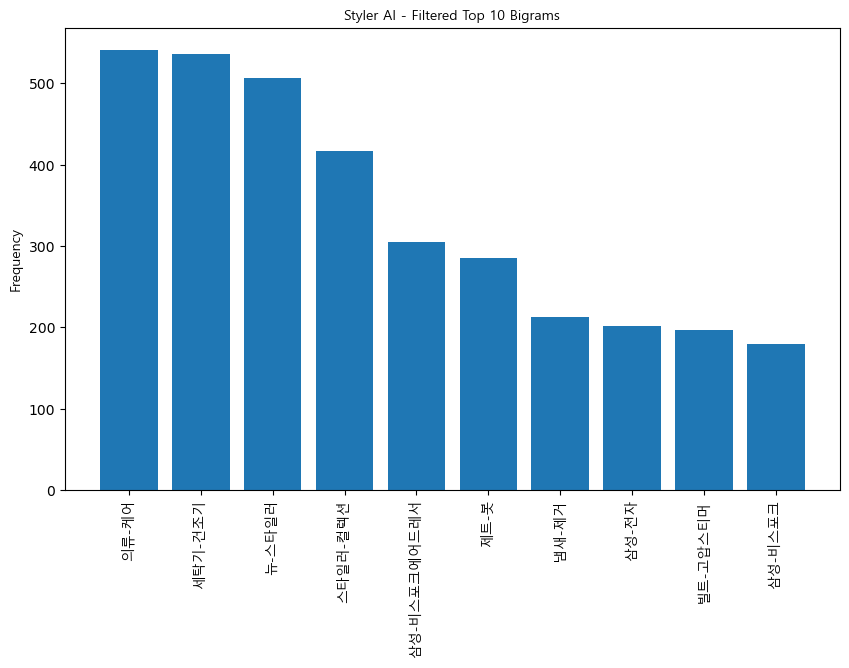

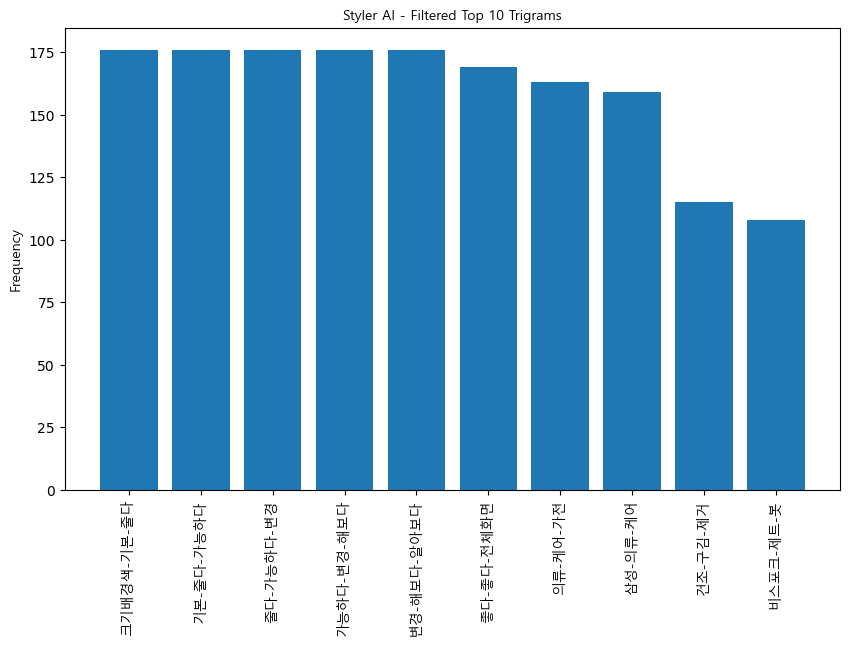

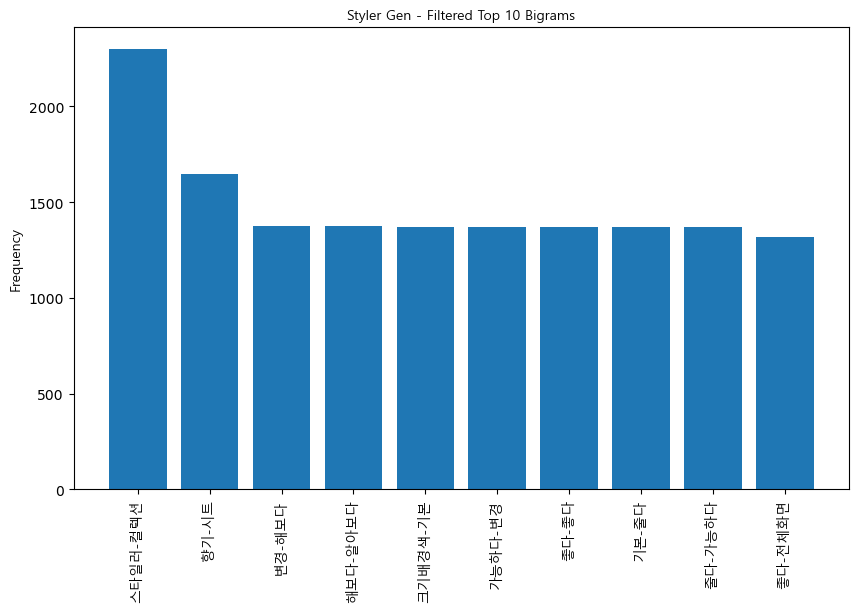

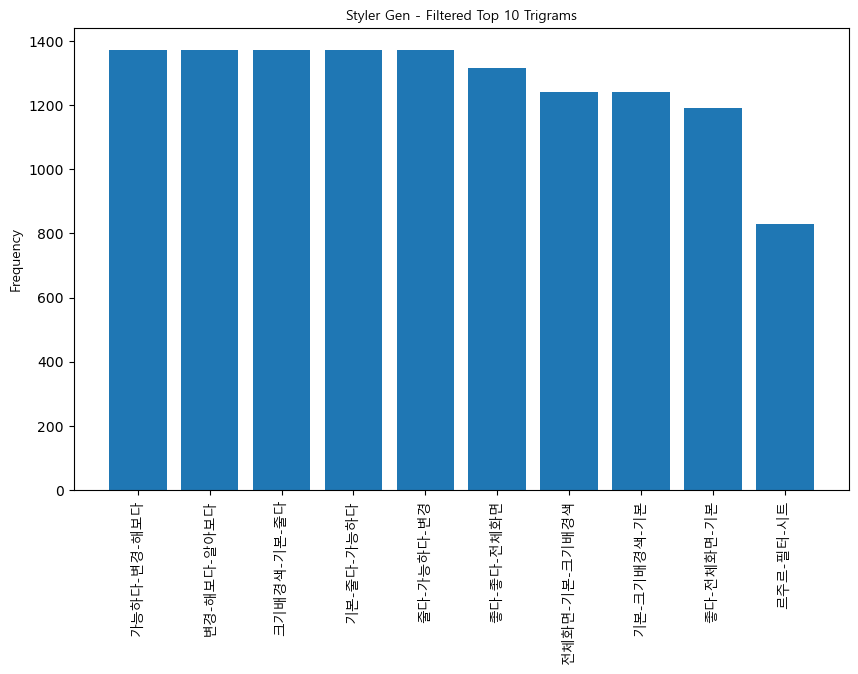

In [19]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 사용 중인 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

# 시각화를 위한 함수 정의
def plot_ngram_frequencies(filtered_bigram_freq, filtered_trigram_freq, dataset_name):
    
    # Filtered Bigram Plot
    plt.figure(figsize=(10, 6))
    bigram_labels, bigram_values = zip(*filtered_bigram_freq.most_common(10))

    plt.bar(range(len(bigram_labels)), bigram_values, tick_label=[f'{x[0]}-{x[1]}' for x in bigram_labels])
    plt.xticks(rotation=90, fontproperties=font_prop)
    plt.title(f"{dataset_name} - Filtered Top 10 Bigrams", fontproperties=font_prop)
    plt.ylabel("Frequency", fontproperties=font_prop)
    plt.show()

    # Filtered Trigram Plot
    plt.figure(figsize=(10, 6))
    trigram_labels, trigram_values = zip(*filtered_trigram_freq.most_common(10))

    plt.bar(range(len(trigram_labels)), trigram_values, tick_label=[f'{x[0]}-{x[1]}-{x[2]}' for x in trigram_labels])
    plt.xticks(rotation=90, fontproperties=font_prop)
    plt.title(f"{dataset_name} - Filtered Top 10 Trigrams", fontproperties=font_prop)
    plt.ylabel("Frequency", fontproperties=font_prop)
    plt.show()

# 각 데이터셋에 대해 그래프 생성
plot_ngram_frequencies(filtered_bigram_freq_styler_ai, filtered_trigram_freq_styler_ai, "Styler AI")
plot_ngram_frequencies(filtered_bigram_freq_styler_gen, filtered_trigram_freq_styler_gen, "Styler Gen")


### top30 빈도

In [20]:
# 상위 30개 단어와 빈도, 비중(%)을 출력하는 함수
def print_top_combined_frequencies_with_percentage(content, filtered_bigram_freq, filtered_trigram_freq, dataset_name):
    # 단어 빈도 계산
    all_tokens = list(chain(*content))
    token_freq = Counter(all_tokens)

    # 단어 빈도와 n-gram 빈도 합치기
    combined_freq = token_freq

    # 전체 빈도 합
    total_freq = sum(combined_freq.values())

    # 상위 30개 추출
    top_30_combined = combined_freq.most_common(30)

    # 결과 출력
    print(f"Top 30 Combined Words & N-grams for {dataset_name}:")
    for word, freq in top_30_combined:
        percentage = (freq / total_freq) * 100
        print(f"{word}: {freq} ({percentage:.2f}%)")
    print("\n")

# 각 데이터셋에 대해 상위 30개 출력
print_top_combined_frequencies_with_percentage(merged_styler_ai_content, filtered_bigram_freq_styler_ai, filtered_trigram_freq_styler_ai, "Styler AI")
print_top_combined_frequencies_with_percentage(merged_styler_gen_content, filtered_bigram_freq_styler_gen, filtered_trigram_freq_styler_gen, "Styler Gen")

Top 30 Combined Words & N-grams for Styler AI:
옷: 2470 (0.77%)
기능: 2255 (0.70%)
제품: 2111 (0.66%)
스타일러: 1953 (0.61%)
관리: 1773 (0.55%)
에어드레서: 1750 (0.55%)
좋다: 1680 (0.52%)
삼성: 1525 (0.48%)
가전: 1479 (0.46%)
가능하다: 1364 (0.43%)
코스: 1263 (0.39%)
건조기: 1234 (0.39%)
공간: 1153 (0.36%)
다양하다: 1057 (0.33%)
건조: 1024 (0.32%)
케어: 1019 (0.32%)
전자: 971 (0.30%)
받다: 965 (0.30%)
의류: 938 (0.29%)
설치: 929 (0.29%)
많다: 927 (0.29%)
살균: 924 (0.29%)
구매: 916 (0.29%)
자다: 904 (0.28%)
세탁: 899 (0.28%)
시간: 881 (0.28%)
의류관리: 863 (0.27%)
스팀: 818 (0.26%)
제거: 782 (0.24%)
기술: 780 (0.24%)


Top 30 Combined Words & N-grams for Styler Gen:
스타일러: 14825 (1.30%)
옷: 11142 (0.98%)
좋다: 9555 (0.84%)
관리: 9049 (0.79%)
제품: 7566 (0.66%)
의류관리: 6767 (0.59%)
기능: 6091 (0.53%)
향: 5359 (0.47%)
가능하다: 5049 (0.44%)
넣다: 4851 (0.42%)
냄새: 4563 (0.40%)
건조기: 4437 (0.39%)
자다: 4398 (0.39%)
살균: 4393 (0.38%)
코스: 4336 (0.38%)
에어드레서: 4245 (0.37%)
의류: 4227 (0.37%)
건조: 4219 (0.37%)
세탁: 4088 (0.36%)
케어: 3754 (0.33%)
시간: 3725 (0.33%)
시트: 3719 (0.33%)
옷장: 3574 (0.

### 전체 top30 빈도 막대 그래프

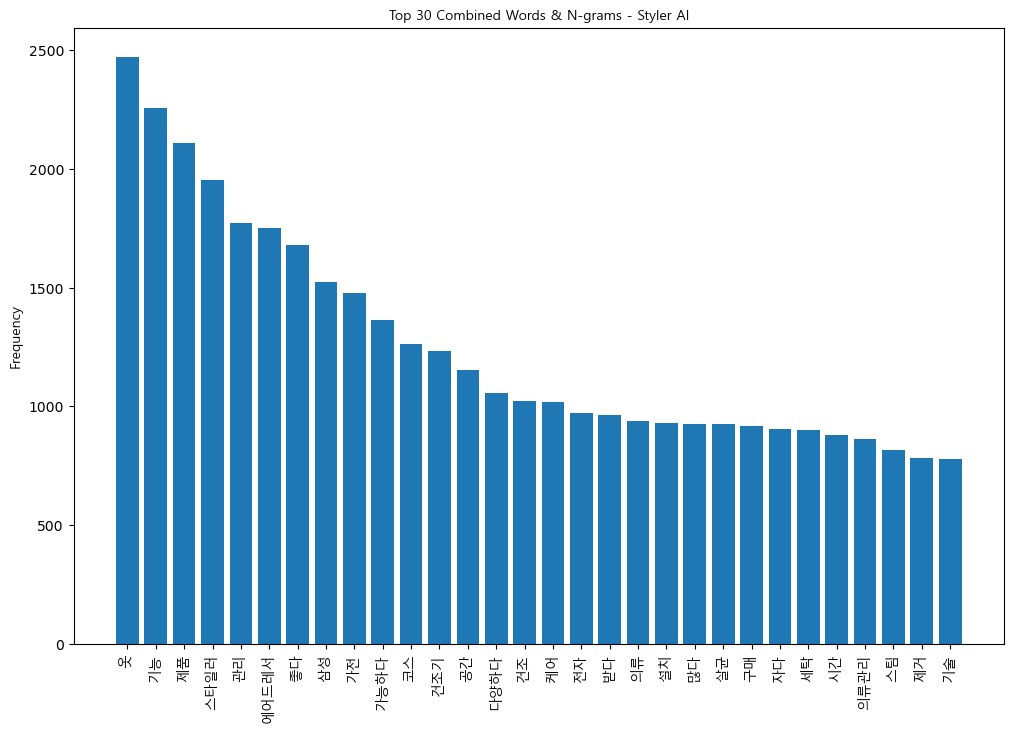

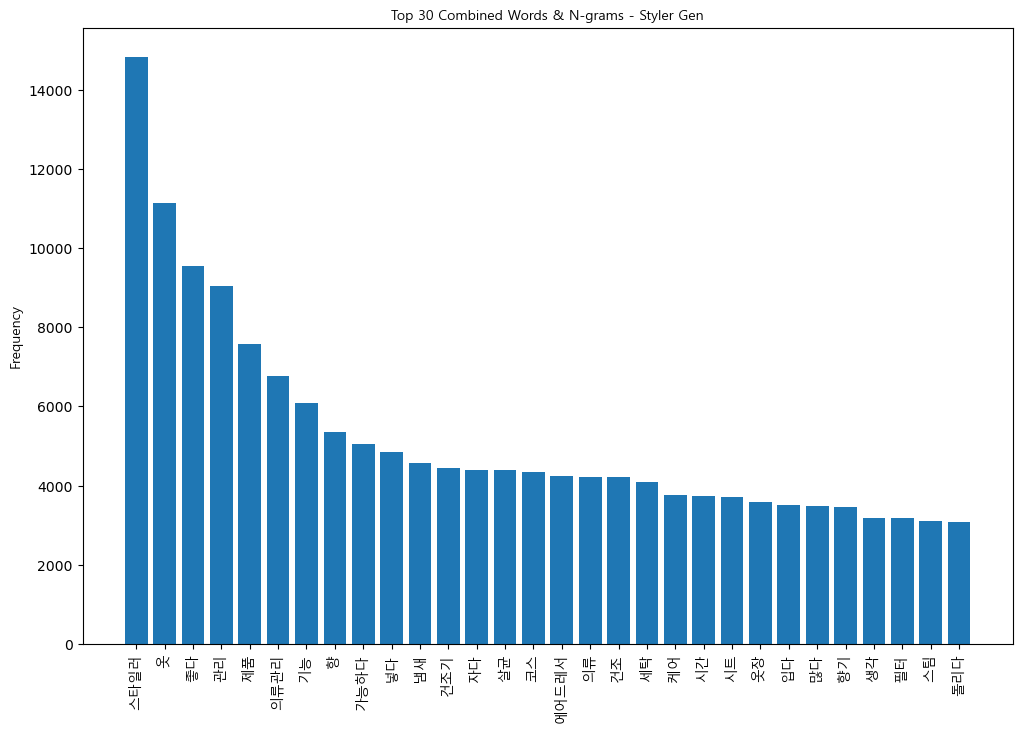

In [21]:
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from matplotlib import font_manager

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = font_manager.FontProperties(fname=font_path)

# 빈도 시각화를 위한 함수 정의
def plot_top_combined_frequencies(content, filtered_bigram_freq, filtered_trigram_freq, dataset_name):
    # 단어 빈도 계산
    all_tokens = list(chain(*content))
    token_freq = Counter(all_tokens)

    # 단어 빈도와 n-gram 빈도 합치기
    combined_freq = token_freq + filtered_bigram_freq + filtered_trigram_freq

    # 상위 30개 추출
    top_30_combined = combined_freq.most_common(30)

    # 그래프 그리기
    plt.figure(figsize=(12, 8))
    labels, values = zip(*top_30_combined)

    plt.bar(range(len(labels)), values, tick_label=[f'{label}' for label in labels])
    plt.xticks(rotation=90, fontproperties=font_prop)
    plt.title(f"Top 30 Combined Words & N-grams - {dataset_name}", fontproperties=font_prop)
    plt.ylabel("Frequency", fontproperties=font_prop)
    plt.show()

# 각 데이터셋에 대해 그래프 생성
plot_top_combined_frequencies(merged_styler_ai_content, filtered_bigram_freq_styler_ai, filtered_trigram_freq_styler_ai, "Styler AI")
plot_top_combined_frequencies(merged_styler_gen_content, filtered_bigram_freq_styler_gen, filtered_trigram_freq_styler_gen, "Styler Gen")

### WordCloud

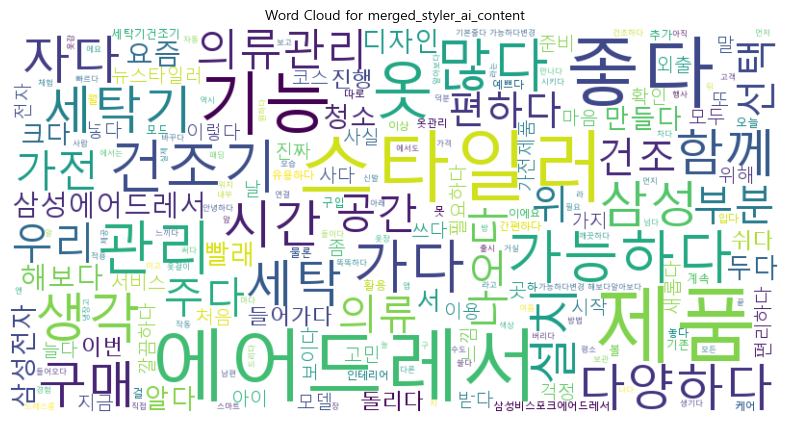

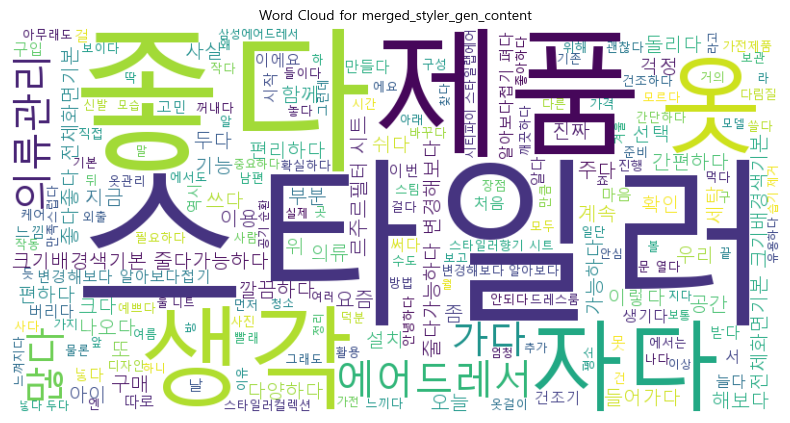

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from itertools import chain

# merged_styler_ai_content, merged_styler_gen_content, merged_vacuum_ai_content, merged_vacuum_gen_content에 대해 워드클라우드 생성

# 리스트를 평탄화하여 하나의 텍스트로 결합하는 함수 정의
def generate_wordcloud(content, title):
    # 리스트 안의 리스트를 평탄화
    flattened_content = list(chain(*content))
    text = " ".join(flattened_content)

    # 워드클라우드 생성
    wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', width=800, height=400, background_color='white').generate(text)

    # 워드클라우드 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")  # 축 제거
    plt.title(title, fontproperties=font_prop)
    plt.show()

# 각 데이터셋에 대해 워드클라우드 생성
generate_wordcloud(merged_styler_ai_content, "Word Cloud for merged_styler_ai_content")
generate_wordcloud(merged_styler_gen_content, "Word Cloud for merged_styler_gen_content")

## 단점 네트워크

In [23]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # DTM
import networkx as nx

def get_ttm(content_list):
    countVectorizer = CountVectorizer()
    dtm = countVectorizer.fit_transform(content_list)
    dtm_dense = dtm.todense()
    words = countVectorizer.get_feature_names_out()

    # term-term matrix
    ttm = np.dot(dtm_dense.T, dtm_dense)
    ttm_df = pd.DataFrame(ttm, index=words, columns=words)

    return ttm_df

In [24]:
def plot_word_graph(ttm_df, center_word, highlight_words, n=50):

    font_location = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_location).get_name()

    # 50개 단어 추출
    related_words = ttm_df[center_word].sort_values(ascending=False).head(n+1)
    related_words = related_words[related_words.index != center_word]
    selected_words = related_words.head(n).index.tolist()

    # 그래프 생성
    G = nx.Graph()
    for word in selected_words:
        weight = ttm_df[center_word][word]
        if weight > 0:
            G.add_edge(center_word, word, weight=weight)

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.axis("off")

    pos = nx.spring_layout(G, seed=42, k=0.5)

    # 중심어
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[center_word],
        node_color="lightcoral",
        node_size=2000,
        alpha=1,
    )

    # 중심어 외 단어 그리기
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[node for node in G.nodes() if node != center_word],
        node_color="white",
        edgecolors="none",
        node_size=500,
        alpha=1,
    )

    nx.draw_networkx_edges(G, pos, edge_color="lightcoral")

    for node, (x, y) in pos.items():
        if node in highlight_words:
            bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", linewidth=1)
        elif node == center_word:
            bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="none", linewidth=1)
        else:
            bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="none")
        plt.text(
            x,
            y,
            node,
            fontsize=12,
            fontproperties=font_manager.FontProperties(fname=font_location),
            ha="center",
            va="center",
            bbox=bbox_props,
        )

    plt.show()

### 일반 의류관리기

#### 단점 앞뒤 30단어

In [25]:
def filter_keyword_context(content, keyword, n, method):
    result = []

    for words in content:
        filtered = []
        if keyword in words:
            index = words.index(keyword)
            if method == 'forward':
                filtered = words[max(0, index - n):index + 1]
            elif method == 'backward':
                filtered = words[index:index + n + 1]
            elif method == 'both':
                filtered = words[max(0, index - n):index + n + 1]
        result.append(filtered)

    return result

In [26]:
filtered_styler_gen_content = filter_keyword_context(merged_styler_gen_content, keyword='단점', n=30, method='backward')
styler_gen_list1 = [" ".join(inner_list) for inner_list in filtered_styler_gen_content]

styler_gen_ttm1 = get_ttm(styler_gen_list1)

In [27]:
non_empty_count = sum(1 for sublist in filtered_styler_gen_content if sublist)
print(non_empty_count)

156


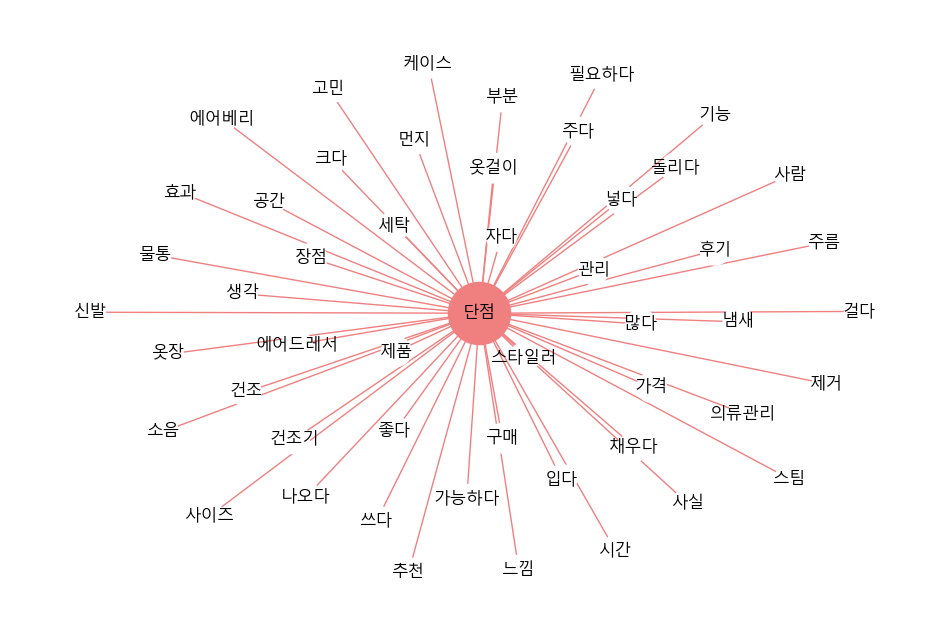

In [28]:
highlight_words = []
plot_word_graph(styler_gen_ttm1, '단점', highlight_words)

#### 불만 리스트 생성

In [29]:
target_words = ['단점', '불만', '불만족', '불편', '별로', '불편하다', '아쉽다']
modified_styler_gen_content = [
    ['단점' if word in target_words else word for word in words]
    for words in merged_styler_gen_content
]

filtered_styler_gen_content = filter_keyword_context(modified_styler_gen_content, keyword='단점', n=30, method='both')
styler_gen_list2 = [" ".join(inner_list) for inner_list in filtered_styler_gen_content]

styler_gen_ttm2 = get_ttm(styler_gen_list2)

In [30]:
non_empty_count = sum(1 for sublist in filtered_styler_gen_content if sublist)
print(non_empty_count)

900


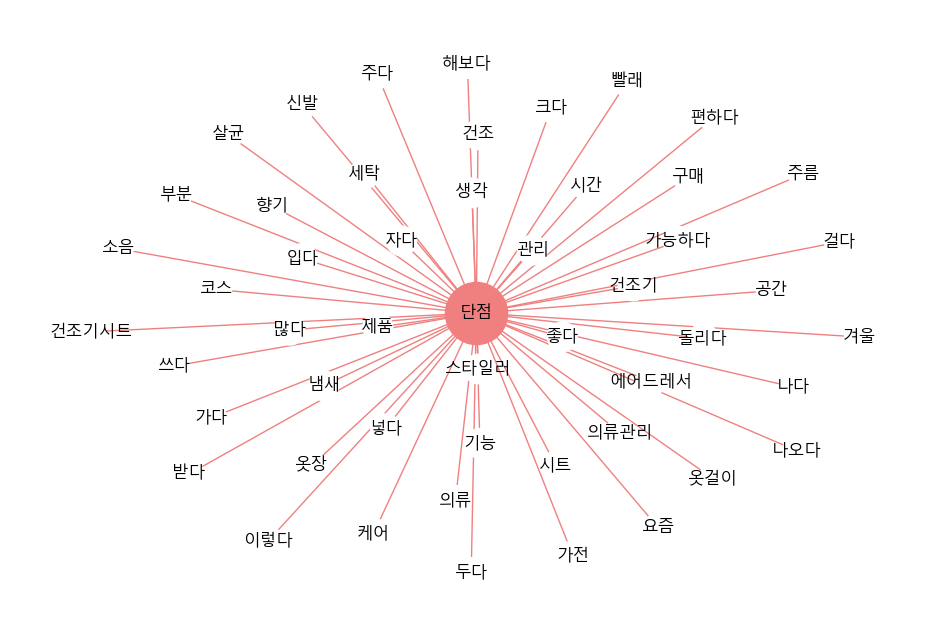

In [31]:
highlight_words = []
plot_word_graph(styler_gen_ttm2, '단점', highlight_words)

### AI 의류관리기

#### 단점 앞뒤 30단어

In [ ]:
filtered_styler_ai_content = filter_keyword_context(merged_styler_ai_content, keyword='단점', n=30, method='backward')
styler_ai_list1 = [" ".join(inner_list) for inner_list in filtered_styler_ai_content]

styler_ai_ttm1 = get_ttm(styler_ai_list1)

In [ ]:
non_empty_count = sum(1 for sublist in filtered_styler_ai_content if sublist)
print(non_empty_count)

In [ ]:
highlight_words = []
plot_word_graph(styler_ai_ttm1, '단점', highlight_words)

#### 불만 리스트 생성

In [ ]:
target_words = ['단점', '불만', '불만족', '불편', '별로', '불편하다', '아쉽다']
modified_styler_ai_content = [
    ['단점' if word in target_words else word for word in words]
    for words in merged_styler_ai_content
]

filtered_styler_ai_content = filter_keyword_context(modified_styler_ai_content, keyword='단점', n=30, method='both')
styler_ai_list2 = [" ".join(inner_list) for inner_list in filtered_styler_ai_content]

styler_ai_ttm2 = get_ttm(styler_ai_list2)

In [ ]:
non_empty_count = sum(1 for sublist in filtered_styler_ai_content if sublist)
print(non_empty_count)

In [ ]:
highlight_words = []
plot_word_graph(styler_ai_ttm2, '단점', highlight_words)

### 의류관리기

#### 단점 뒤 30단어

In [ ]:
merged_styler_content = merged_styler_gen_content + merged_styler_ai_content
filtered_styler_content = filter_keyword_context(merged_styler_content, keyword='단점', n=30, method='backward')
styler_list1 = [" ".join(inner_list) for inner_list in filtered_styler_content]

styler_ttm1 = get_ttm(styler_list1)

In [ ]:
non_empty_count = sum(1 for sublist in filtered_styler_content if sublist)
print(non_empty_count)

201


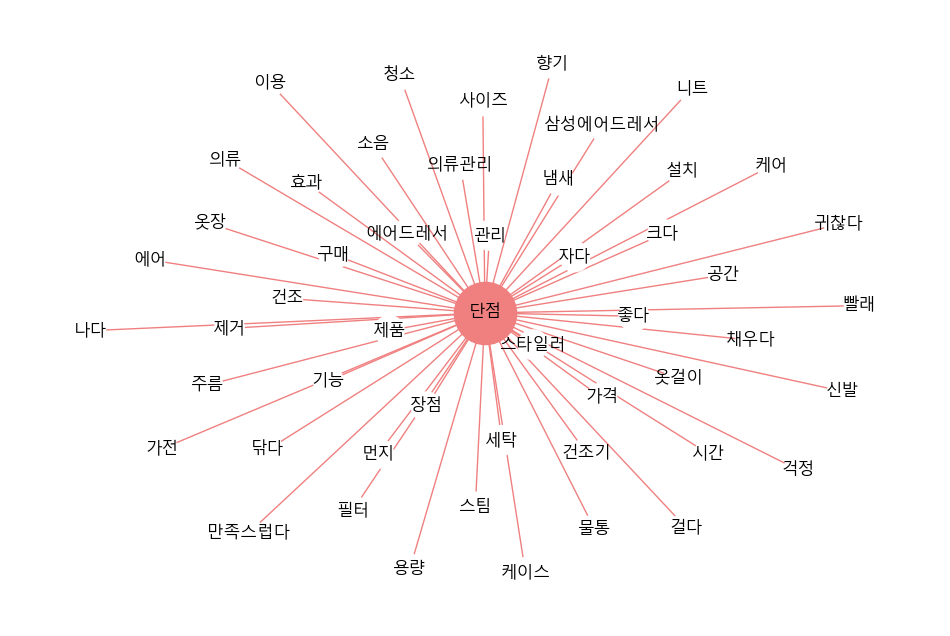

In [ ]:
highlight_words = []
plot_word_graph(styler_ttm1, '단점', highlight_words)

#### 불만 리스트 생성

In [ ]:
target_words = ['단점', '불만', '불만족', '불편', '별로', '불편하다', '아쉽다']
modified_styler_content = [
    ['단점' if word in target_words else word for word in words]
    for words in merged_styler_content
]

filtered_styler_content = filter_keyword_context(modified_styler_content, keyword='단점', n=30, method='both')
styler_list2 = [" ".join(inner_list) for inner_list in filtered_styler_content]

styler_ttm2 = get_ttm(styler_list2)

In [ ]:
non_empty_count = sum(1 for sublist in filtered_styler_content if sublist)
print(non_empty_count)

In [ ]:
highlight_words = []
plot_word_graph(styler_ttm2, '단점', highlight_words)

## 네트워크 분석

In [33]:
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Twitter
from konlpy.tag import Okt
from matplotlib import font_manager, rc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from itertools import chain

#### AI 의류관리기와 일반 의류관리기 분리

In [34]:
# word_data1 : styler_ai 전처리 후
# word_data2 : styler_gen 전처리 후

words = list(chain.from_iterable(merged_styler_ai_content))
count = Counter(words)

word_list = pd.Series(words)
data1 = word_list.value_counts().head(40)

df1 = data1.to_frame()
df1.to_csv('styler_ai_top40.csv')
word_data1 = pd.read_csv('styler_ai_top40.csv', names=['단어','빈도'])

word_data1.dropna(axis=0, inplace=True)
word_data1['styler'] = 'styler_ai'
word_data1

words = list(chain.from_iterable(merged_styler_gen_content))
count = Counter(words)

word_list = pd.Series(words)
data2 = word_list.value_counts().head(40)

df2 = data2.to_frame()
df2.to_csv('styler_gen_top40.csv')
word_data2 = pd.read_csv('styler_gen_top40.csv', names=['단어','빈도'])

word_data2.dropna(axis=0, inplace=True)
word_data2['styler'] = 'styler_gen'
word_data2

,단어,빈도,styler
1,스타일러,14825,styler_gen
2,옷,11142,styler_gen
3,좋다,9555,styler_gen
4,관리,9049,styler_gen
5,제품,7566,styler_gen
6,의류관리,6767,styler_gen
7,기능,6091,styler_gen
8,향,5359,styler_gen
9,가능하다,5049,styler_gen
10,넣다,4851,styler_gen


#### 시각화

In [35]:
dataframe = pd.concat([word_data1, word_data2], ignore_index=True)
dataframe

,단어,빈도,styler
0,옷,2470,styler_ai
1,기능,2255,styler_ai
2,제품,2111,styler_ai
3,스타일러,1953,styler_ai
4,관리,1773,styler_ai
...,...,...,...
75,먼지,2773,styler_gen
76,미세먼지,2738,styler_gen
77,해보다,2662,styler_gen
78,구매,2573,styler_gen


In [36]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import networkx as nx

# 한글 폰트 설정
#font_path = "~/Fonts/NanumBarunGothic.ttf"  # 폰트 경로
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['axes.unicode_minus'] = False  # 한글 깨짐 방지

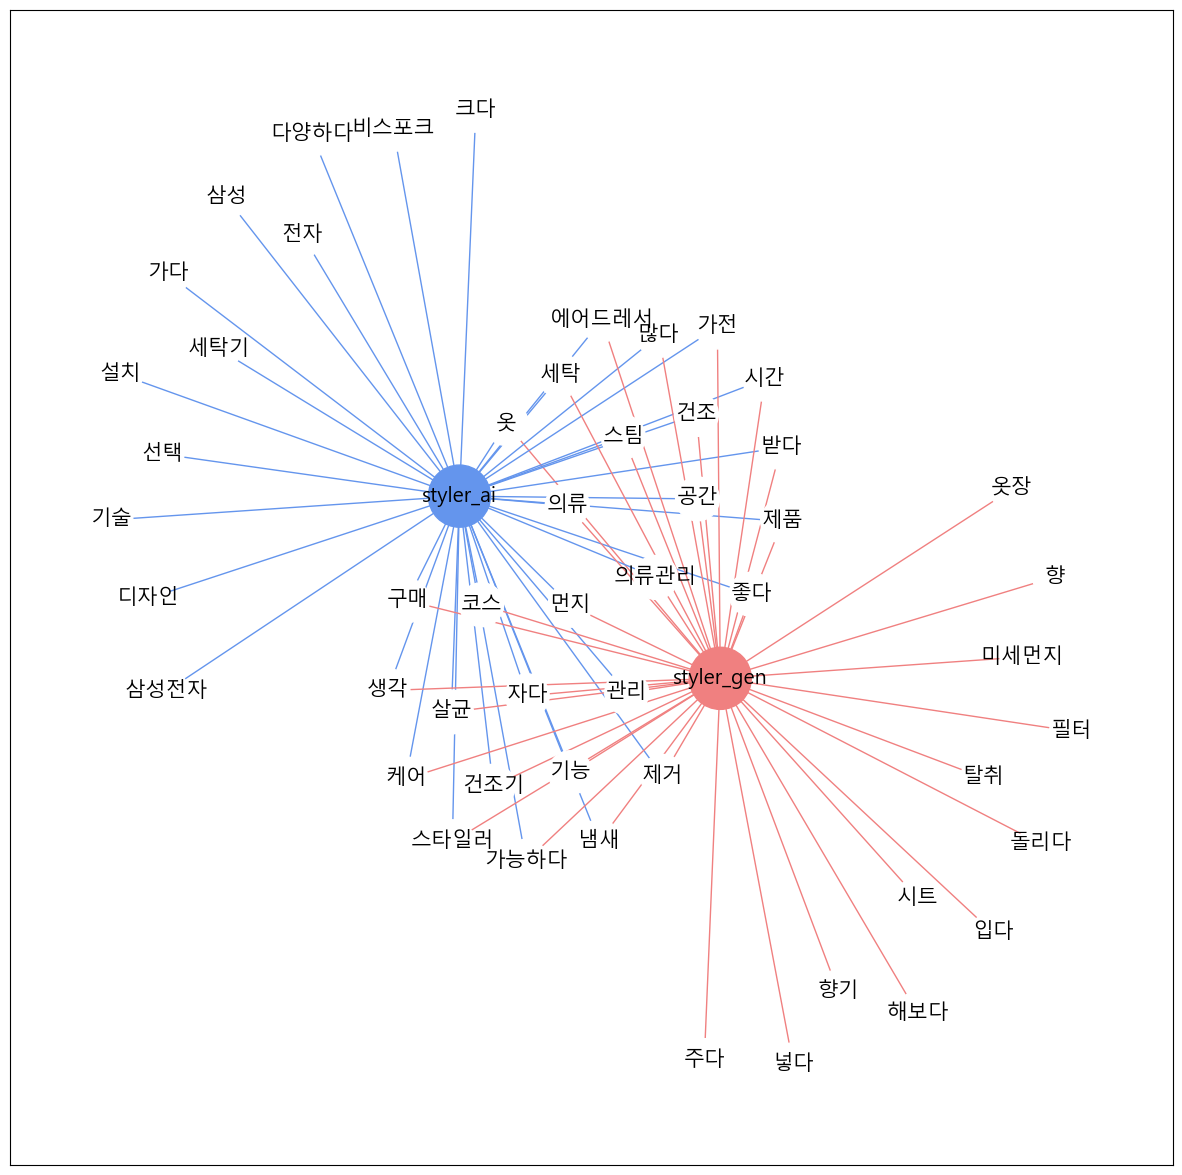

In [42]:
## 네트워크 그래프

g = nx.karate_club_graph()
g = nx.from_pandas_edgelist(dataframe, source='단어', target='styler')
pos = nx.spring_layout(g, k=0.7, iterations=200, scale=2)

color_map_node=[]
node_size_map = []
for node in g:
    if node == 'styler_gen':
        color_map_node.append('lightcoral')
        node_size_map.append(2000)
    elif node == 'styler_ai':
        color_map_node.append('cornflowerblue')
        node_size_map.append(2000)
    else:
        color_map_node.append('white')
        node_size_map.append(1000)

color_map_edge=[]
for edges in g.edges():
    if 'styler_gen' in edges:
        color_map_edge.append('lightcoral')
    if 'styler_ai' in edges:
        color_map_edge.append('cornflowerblue')

plt.figure(figsize=(15, 15))

nx.draw_networkx_nodes(g, pos, node_size=node_size_map, node_color=color_map_node)
nx.draw_networkx_edges(g, pos, width=1, edge_color = color_map_edge)

# 노드 라벨 추가 (한글 폰트 적용)
labels = {node: str(node) for node in g.nodes()}  # 노드 이름 매핑
for key, (x, y) in pos.items():
    plt.text(x, y, labels[key], fontsize=15, fontproperties=font_prop, ha='center', va='center')

plt.show()